In [8]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import json
import os
import time
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import ttest_rel
from tabpfn import TabPFNClassifier
from autogluon.tabular import TabularPredictor

# Suppress warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

print("Setup complete. Libraries loaded.")

Setup complete. Libraries loaded.


In [9]:
# Cell 2: Constants and Metadata Setup
DATA_FILE = '/home/vulcan/Abhay/Projects/ADA/Dataset/cleaned_aadhaar_dataset.csv'
RESULTS_FILE = 'sanity_check_results.csv'
METADATA_FILE = 'sanity_check_metadata.json'

# Experiment Parameters
N_REPEATS = 20
TRAIN_SAMPLE_SIZE = 1024
TEST_SAMPLE_SIZE = 500
AG_TIME_LIMIT = 300  # 5 minutes per run

# Define the 7 simple features for this experiment
SIMPLE_FEATURES = [
    'state', 
    'district', 
    'age_0_5', 
    'age_5_17', 
    'age_18_greater', 
    'month', # Will be created
    'day_of_week' # Will be created
]
CATEGORICAL_FEATURES = ['state', 'district']

# Define Targets
TARGET_TASK1 = 'is_anomaly'
TARGET_TASK3 = 'high_inequality'

# Create metadata dictionary (as you suggested)
metadata = {
    "experiment_name": "Phase 2: Sanity Check (TabPFN vs. AutoGluon)",
    "run_timestamp_utc": datetime.utcnow().isoformat(),
    "n_repeats": N_REPEATS,
    "train_sample_size": TRAIN_SAMPLE_SIZE,
    "test_sample_size": TEST_SAMPLE_SIZE,
    "ag_time_limit_seconds": AG_TIME_LIMIT,
    "simple_features_used": SIMPLE_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "target_task1": TARGET_TASK1,
    "target_task3": TARGET_TASK3
}
print(f"✓ Metadata dictionary created. {N_REPEATS} repeats planned.")

✓ Metadata dictionary created. 20 repeats planned.


In [10]:
# Cell 3: Load Raw Data
print(f"Loading raw data: {DATA_FILE}...")
try:
    df_base = pd.read_csv(DATA_FILE)
except FileNotFoundError:
    print(f"Error: '{DATA_FILE}' not found.")
    raise

df_base['date'] = pd.to_datetime(df_base['date'])
# Sort once
df_base = df_base.sort_values(['state', 'district', 'pincode', 'date']).reset_index(drop=True)

# Create a working copy (as you recommended)
df = df_base.copy()
print(f"✓ Data loaded successfully: {df.shape}")

Loading raw data: /home/vulcan/Abhay/Projects/ADA/Dataset/cleaned_aadhaar_dataset.csv...
✓ Data loaded successfully: (219091, 7)


In [11]:
# Cell 4: Minimal Feature Engineering (Prerequisites for Targets)
print("Running minimal feature engineering to create target dependencies...")

# --- From Cell 4: Demographic Features ---
df['total_enrollments'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# --- From Cell 5: Lag Features (dependencies for z_score_rolling) ---
group_cols = ['state', 'district', 'pincode']
# Note: Using fast, vectorized .transform() so tqdm isn't needed here
df['total_enrollments_rolling_mean_7d'] = df.groupby(group_cols)['total_enrollments'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df['total_enrollments_rolling_std_7d'] = df.groupby(group_cols)['total_enrollments'].transform(
    lambda x: x.rolling(7, min_periods=1).std()
)

# --- From Cell 6: Spatial Features (dependencies for z_score_state) ---
state_stats = df.groupby(['state', 'date']).agg({
    'total_enrollments': ['mean', 'std']
}).reset_index()
state_stats.columns = ['state', 'date', 'state_mean', 'state_std']
df = df.merge(state_stats, on=['state', 'date'], how='left')

# --- From Cell 7: Anomaly Detection Features (the final dependencies) ---
df['z_score_state'] = (df['total_enrollments'] - df['state_mean']) / (df['state_std'] + 1e-10)
df['z_score_rolling'] = (df['total_enrollments'] - df['total_enrollments_rolling_mean_7d']) / (df['total_enrollments_rolling_std_7d'] + 1e-10)
df['enrollment_volatility'] = df['total_enrollments_rolling_std_7d'] / (df['total_enrollments_rolling_mean_7d'] + 1e-10)

# Sanitize inf and NaN values (crucial for stability)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0) 

print("✓ Prerequisite features created.")

Running minimal feature engineering to create target dependencies...
✓ Prerequisite features created.


In [12]:
# Cell 5: Target Variable Creation (Your "Ground Truth" Logic)
print("Creating target variables (leak-free)...")

# Compute train/test cutoff BEFORE creating targets
TRAIN_TEST_CUTOFF = df['date'].quantile(0.8)
train_mask = df['date'] <= TRAIN_TEST_CUTOFF
metadata['time_cutoff'] = TRAIN_TEST_CUTOFF.isoformat() # Add to metadata
print(f"  Train/Test cutoff date: {TRAIN_TEST_CUTOFF.date()}")

# === Task 1: Anomaly Detection ===
volatility_threshold = df.loc[train_mask, 'enrollment_volatility'].quantile(0.95)
metadata['task1_volatility_threshold'] = volatility_threshold # Add to metadata
df[TARGET_TASK1] = (
    (abs(df['z_score_rolling']) > 2) |
    (abs(df['z_score_state']) > 2.5) |
    (df['enrollment_volatility'] > volatility_threshold)
).astype(int)
print(f"  Task 1 '{TARGET_TASK1}' created.")

# === Task 3: Spatial Inequality ===
threshold_inequality = df.loc[train_mask, 'z_score_state'].quantile(0.90)
metadata['task3_inequality_threshold'] = threshold_inequality # Add to metadata
df[TARGET_TASK3] = (df['z_score_state'] > threshold_inequality).astype(int)
print(f"  Task 3 '{TARGET_TASK3}' created.")

print("✓ Target variables are now in the DataFrame.")

Creating target variables (leak-free)...
  Train/Test cutoff date: 2025-09-25
  Task 1 'is_anomaly' created.
  Task 3 'high_inequality' created.
✓ Target variables are now in the DataFrame.


In [13]:
# Cell 6: Data & Encoder Setup (for Sanity Check)
print("Setting up simple DataFrames and Encoders...")

# --- Create the missing simple features ---
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

# --- Create Task-Specific DataFrames for the experiment ---
df_task1 = df[SIMPLE_FEATURES + [TARGET_TASK1, 'date']]
df_task3 = df[SIMPLE_FEATURES + [TARGET_TASK3, 'date']]
print("✓ Simple DataFrames for Tasks 1 and 3 created.")

# --- Create Full Train/Test Splits for Sampling ---
# Task 1 Split
train_mask_t1 = df_task1['date'] <= TRAIN_TEST_CUTOFF
test_mask_t1 = df_task1['date'] > TRAIN_TEST_CUTOFF
X_train_full_t1 = df_task1[train_mask_t1].drop(columns=['date'])
X_test_full_t1 = df_task1[test_mask_t1].drop(columns=['date'])

# Task 3 Split
train_mask_t3 = df_task3['date'] <= TRAIN_TEST_CUTOFF
test_mask_t3 = df_task3['date'] > TRAIN_TEST_CUTOFF
X_train_full_t3 = df_task3[train_mask_t3].drop(columns=['date'])
X_test_full_t3 = df_task3[test_mask_t3].drop(columns=['date'])

print(f"Task 1: {len(X_train_full_t1)} train rows | {len(X_test_full_t1)} test rows")
print(f"Task 3: {len(X_train_full_t3)} train rows | {len(X_test_full_t3)} test rows")

# --- Create Consistent Encoders ---
print("Fitting OrdinalEncoders on full simple training set...")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
all_cats = pd.concat([X_train_full_t1[CATEGORICAL_FEATURES], X_train_full_t3[CATEGORICAL_FEATURES]]).drop_duplicates()
encoder.fit(all_cats)
print("✓ Encoders are ready.")

def preprocess_for_tabpfn(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X[CATEGORICAL_FEATURES] = encoder.transform(X[CATEGORICAL_FEATURES])
    X = X.fillna(-1)
    return X, y

Setting up simple DataFrames and Encoders...
✓ Simple DataFrames for Tasks 1 and 3 created.
Task 1: 179423 train rows | 39668 test rows
Task 3: 179423 train rows | 39668 test rows
Fitting OrdinalEncoders on full simple training set...
✓ Encoders are ready.


In [18]:
# Cell 7: Run the Sanity Check Experiment Loop
print(f"Starting Sanity Check Experiment: {N_REPEATS} iterations...")

# Delete old results file if it exists
if os.path.exists(RESULTS_FILE):
    os.remove(RESULTS_FILE)
print(f"Cleared old results file: {RESULTS_FILE}")

# Use tqdm for a progress bar over the loop
for i in tqdm(range(N_REPEATS), desc="Experiment Iterations"):
    seed = i
    run_scores = {'seed': seed}
    
    # === Task 1: Anomaly Detection ===
    
    # 1. Stratified sample from train (as recommended)
    train_sample_t1, _ = train_test_split(
        X_train_full_t1,
        train_size=TRAIN_SAMPLE_SIZE,
        stratify=X_train_full_t1[TARGET_TASK1],
        random_state=seed
    )
    # 2. Stratified sample from test (as recommended)
    test_sample_t1, _ = train_test_split(
        X_test_full_t1,
        train_size=TEST_SAMPLE_SIZE,
        stratify=X_test_full_t1[TARGET_TASK1],
        random_state=seed
    )
    
    # 3. Preprocess for TabPFN
    X_train_t1_pfn, y_train_t1_pfn = preprocess_for_tabpfn(train_sample_t1, TARGET_TASK1)
    X_test_t1_pfn, y_test_t1_pfn = preprocess_for_tabpfn(test_sample_t1, TARGET_TASK1)

    # 4. Train & Evaluate TabPFN (with runtime logging)
    start_fit = time.time()
    model_tabpfn_t1 = TabPFNClassifier(device='cuda')
    model_tabpfn_t1.fit(X_train_t1_pfn, y_train_t1_pfn)
    run_scores['T1_TabPFN_fit_time'] = time.time() - start_fit
    
    start_pred = time.time()
    y_pred_tabpfn_t1 = model_tabpfn_t1.predict_proba(X_test_t1_pfn)[:, 1]
    run_scores['T1_TabPFN_predict_time'] = time.time() - start_pred
    
    run_scores['T1_TabPFN_ROC-AUC'] = roc_auc_score(y_test_t1_pfn, y_pred_tabpfn_t1)
    run_scores['T1_TabPFN_PR-AUC'] = average_precision_score(y_test_t1_pfn, y_pred_tabpfn_t1)

    # 5. Train & Evaluate AutoGluon (with runtime logging)
    ag_path_t1 = f'ag_sanity_check/task1_seed{seed}'
    model_ag_t1 = TabularPredictor(label=TARGET_TASK1, eval_metric='roc_auc', path=ag_path_t1, verbosity=0)
    
    start_fit = time.time()
    model_ag_t1.fit(train_sample_t1, presets='medium_quality', time_limit=AG_TIME_LIMIT)
    run_scores['T1_AG_fit_time'] = time.time() - start_fit
    
    start_pred = time.time()
    y_pred_ag_t1 = model_ag_t1.predict_proba(test_sample_t1, as_multiclass=False)
    run_scores['T1_AG_predict_time'] = time.time() - start_pred
    
    run_scores['T1_AG_ROC-AUC'] = roc_auc_score(test_sample_t1[TARGET_TASK1], y_pred_ag_t1)
    run_scores['T1_AG_PR-AUC'] = average_precision_score(test_sample_t1[TARGET_TASK1], y_pred_ag_t1)

    
    # === Task 3: Spatial Inequality ===

    # 1. Stratified sample from train
    train_sample_t3, _ = train_test_split(
        X_train_full_t3,
        train_size=TRAIN_SAMPLE_SIZE,
        stratify=X_train_full_t3[TARGET_TASK3],
        random_state=seed
    )
    # 2. Stratified sample from test
    test_sample_t3, _ = train_test_split(
        X_test_full_t3,
        train_size=TEST_SAMPLE_SIZE,
        stratify=X_test_full_t3[TARGET_TASK3],
        random_state=seed
    )
    
    # 3. Preprocess for TabPFN
    X_train_t3_pfn, y_train_t3_pfn = preprocess_for_tabpfn(train_sample_t3, TARGET_TASK3)
    X_test_t3_pfn, y_test_t3_pfn = preprocess_for_tabpfn(test_sample_t3, TARGET_TASK3)

    # 4. Train & Evaluate TabPFN (with runtime logging)
    start_fit = time.time()
    model_tabpfn_t3 = TabPFNClassifier(device='cuda')
    model_tabpfn_t3.fit(X_train_t3_pfn, y_train_t3_pfn)
    run_scores['T3_TabPFN_fit_time'] = time.time() - start_fit
    
    start_pred = time.time()
    y_pred_tabpfn_t3 = model_tabpfn_t3.predict_proba(X_test_t3_pfn)[:, 1]
    run_scores['T3_TabPFN_predict_time'] = time.time() - start_pred
    
    run_scores['T3_TabPFN_ROC-AUC'] = roc_auc_score(y_test_t3_pfn, y_pred_tabpfn_t3)
    run_scores['T3_TabPFN_PR-AUC'] = average_precision_score(y_test_t3_pfn, y_pred_tabpfn_t3)

    # 5. Train & Evaluate AutoGluon (with runtime logging)
    ag_path_t3 = f'ag_sanity_check/task3_seed{seed}'
    model_ag_t3 = TabularPredictor(label=TARGET_TASK3, eval_metric='roc_auc', path=ag_path_t3, verbosity=0)
    
    start_fit = time.time()
    model_ag_t3.fit(train_sample_t3, presets='medium_quality', time_limit=AG_TIME_LIMIT)
    run_scores['T3_AG_fit_time'] = time.time() - start_fit
    
    start_pred = time.time()
    y_pred_ag_t3 = model_ag_t3.predict_proba(test_sample_t3, as_multiclass=False)
    run_scores['T3_AG_predict_time'] = time.time() - start_pred
    
    run_scores['T3_AG_ROC-AUC'] = roc_auc_score(test_sample_t3[TARGET_TASK3], y_pred_ag_t3)
    run_scores['T3_AG_PR-AUC'] = average_precision_score(test_sample_t3[TARGET_TASK3], y_pred_ag_t3)
    
    # 6. Log results to CSV *inside the loop* (as recommended)
    results_df_iter = pd.DataFrame([run_scores])
    results_df_iter.to_csv(
        RESULTS_FILE, 
        mode='a', 
        header=not os.path.exists(RESULTS_FILE), 
        index=False
    )

print("\nExperiment complete. All iterations saved.")

Starting Sanity Check Experiment: 20 iterations...
Cleared old results file: sanity_check_results.csv


Experiment Iterations: 100%|██████████| 20/20 [09:21<00:00, 28.09s/it]


Experiment complete. All iterations saved.


In [19]:
# Cell 8: Save Metadata
print("\n" + "="*60)
print("SAVING METADATA")
print("="*60)

# Save metadata as a JSON file
with open(METADATA_FILE, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Metadata saved to {METADATA_FILE}")


SAVING METADATA
✓ Metadata saved to sanity_check_metadata.json


In [20]:
# Cell 9: Analyze Sanity Check Results
print("\n" + "="*60)
print(f"SANITY CHECK RESULTS ({N_REPEATS} RUNS)")
print("="*60)

# Load the full results file
results_df = pd.read_csv(RESULTS_FILE)

# Display the statistical summary for scores
print("\n--- Performance Metrics (Mean, Std, Min, Max) ---")
score_cols = [col for col in results_df.columns if 'AUC' in col]
print(results_df[score_cols].describe().T[['mean', 'std', 'min', 'max']])

# Display the statistical summary for timings
print("\n--- Runtime Metrics (Mean, Std, Min, Max) ---")
time_cols = [col for col in results_df.columns if 'time' in col]
print(results_df[time_cols].describe().T[['mean', 'std', 'min', 'max']])

# --- Statistical T-Tests (as recommended) ---
print("\n--- Statistical Significance (Paired T-Test) ---")
# Lower p-value (e.g., < 0.05) means the difference is statistically significant

# Task 1
t1_roc_t, t1_roc_p = ttest_rel(results_df['T1_TabPFN_ROC-AUC'], results_df['T1_AG_ROC-AUC'])
t1_pr_t, t1_pr_p = ttest_rel(results_df['T1_TabPFN_PR-AUC'], results_df['T1_AG_PR-AUC'])
print(f"Task 1 ROC-AUC (TabPFN vs. AG) p-value: {t1_roc_p:.4f}")
print(f"Task 1 PR-AUC  (TabPFN vs. AG) p-value: {t1_pr_p:.4f}")

# Task 3
t3_roc_t, t3_roc_p = ttest_rel(results_df['T3_TabPFN_ROC-AUC'], results_df['T3_AG_ROC-AUC'])
t3_pr_t, t3_pr_p = ttest_rel(results_df['T3_TabPFN_PR-AUC'], results_df['T3_AG_PR-AUC'])
print(f"Task 3 ROC-AUC (TabPFN vs. AG) p-value: {t3_roc_p:.4f}")
print(f"Task 3 PR-AUC  (TabPFN vs. AG) p-value: {t3_pr_p:.4f}")


SANITY CHECK RESULTS (20 RUNS)

--- Performance Metrics (Mean, Std, Min, Max) ---
                       mean       std       min       max
T1_TabPFN_ROC-AUC  0.742940  0.036180  0.652686  0.798096
T1_TabPFN_PR-AUC   0.324453  0.060849  0.224021  0.438636
T1_AG_ROC-AUC      0.692371  0.051032  0.583782  0.784116
T1_AG_PR-AUC       0.268358  0.072814  0.140491  0.410831
T3_TabPFN_ROC-AUC  0.878204  0.035902  0.807022  0.941378
T3_TabPFN_PR-AUC   0.630275  0.066972  0.496394  0.745791
T3_AG_ROC-AUC      0.871742  0.060478  0.747778  0.943644
T3_AG_PR-AUC       0.596261  0.073864  0.413582  0.710775

--- Runtime Metrics (Mean, Std, Min, Max) ---
                            mean       std       min        max
T1_TabPFN_fit_time      0.114538  0.009780  0.102676   0.138294
T1_TabPFN_predict_time  7.609714  0.014514  7.590793   7.657343
T1_AG_fit_time          5.460591  1.166223  4.644588   9.999150
T1_AG_predict_time      0.036866  0.022423  0.006730   0.086985
T3_TabPFN_fit_time      0.11


GENERATING VISUALIZATIONS


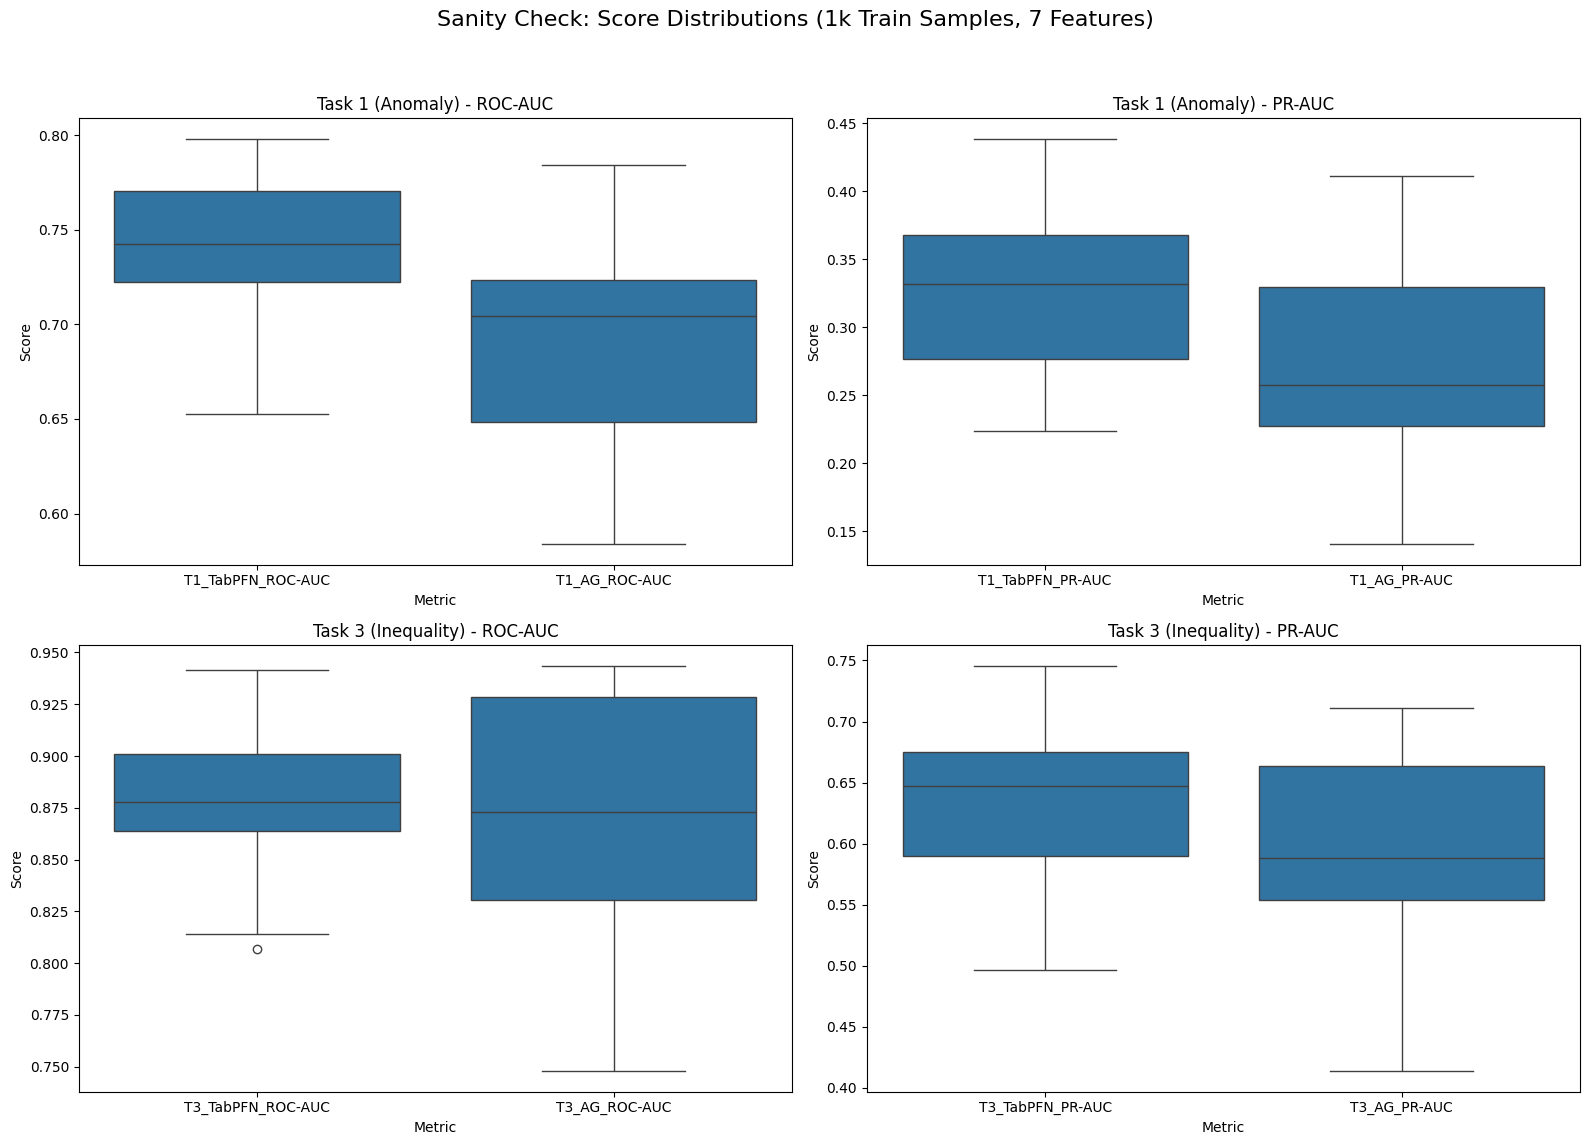

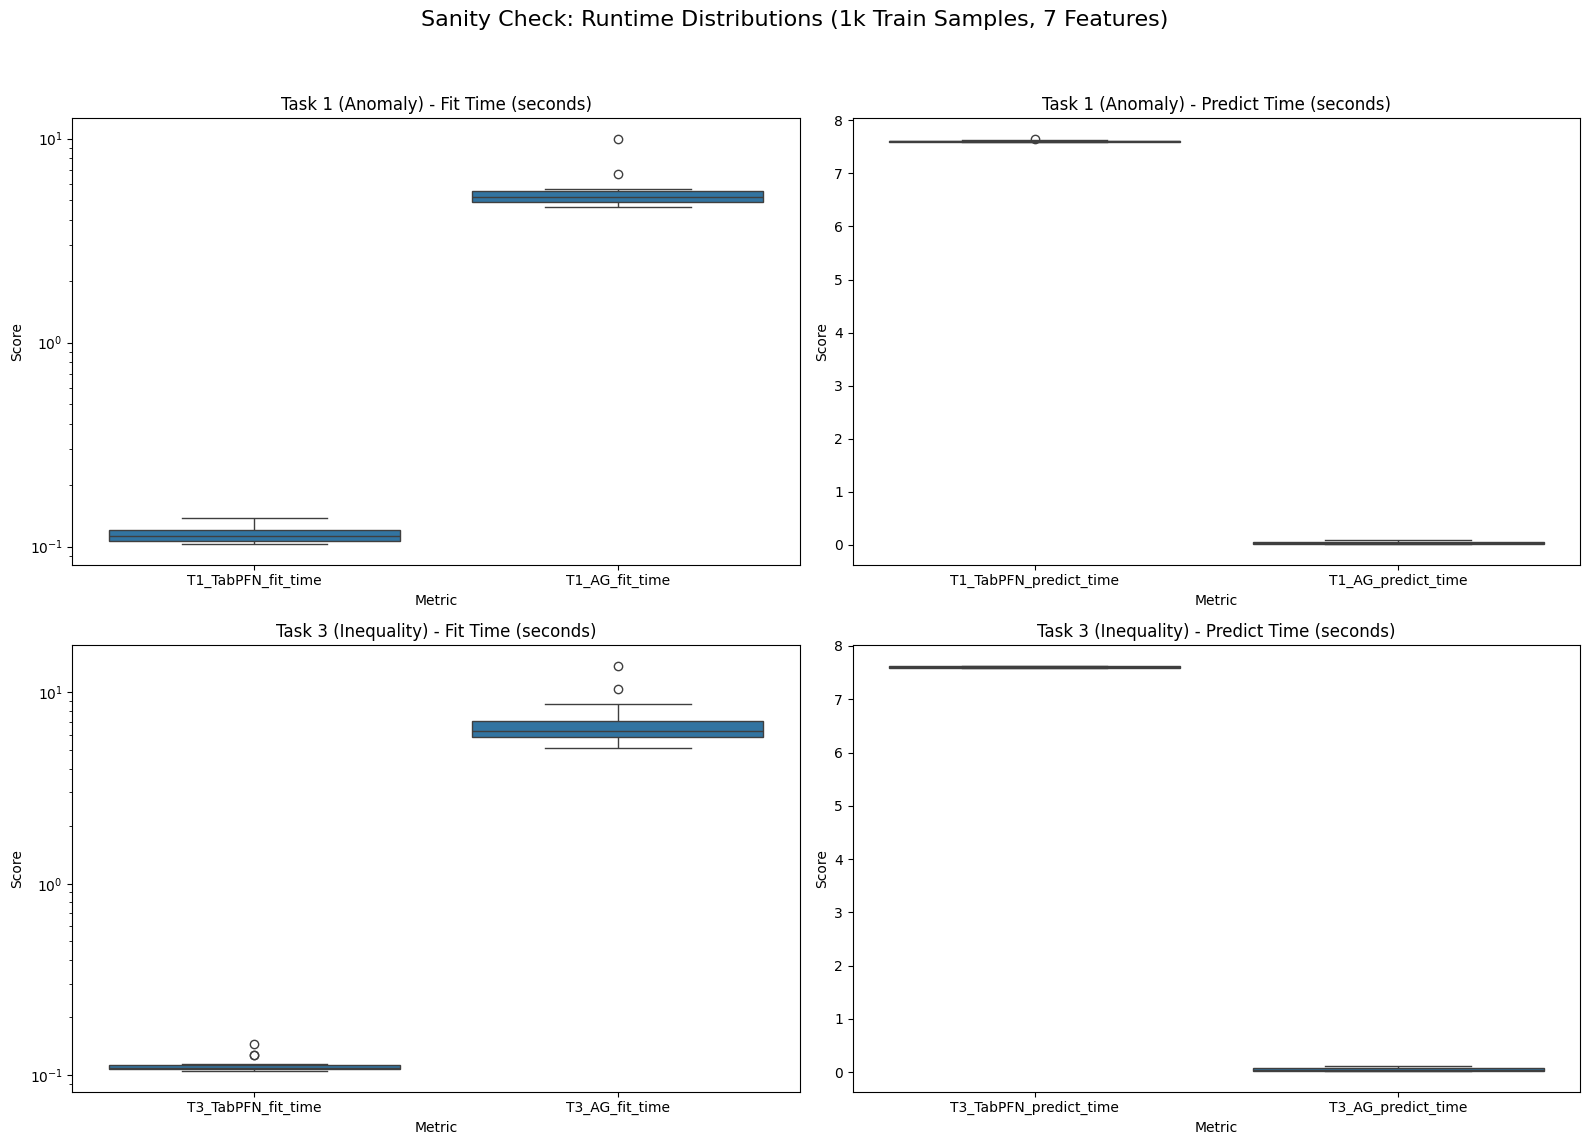


Analysis complete. Check 'sanity_check_scores.png' and 'sanity_check_runtimes.png' for plots.


In [21]:
# Cell 10: Visualization
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Melt the DataFrame for easy plotting with seaborn
    results_melted = results_df.melt(id_vars='seed', var_name='Metric', value_name='Score')

    # --- Score Plots ---
    fig_scores, axes_scores = plt.subplots(2, 2, figsize=(16, 12))
    fig_scores.suptitle('Sanity Check: Score Distributions (1k Train Samples, 7 Features)', fontsize=16)

    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T1_TabPFN_ROC-AUC', 'T1_AG_ROC-AUC'])], 
        x='Metric', y='Score', ax=axes_scores[0, 0]
    ).set_title('Task 1 (Anomaly) - ROC-AUC')

    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T1_TabPFN_PR-AUC', 'T1_AG_PR-AUC'])], 
        x='Metric', y='Score', ax=axes_scores[0, 1]
    ).set_title('Task 1 (Anomaly) - PR-AUC')

    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T3_TabPFN_ROC-AUC', 'T3_AG_ROC-AUC'])], 
        x='Metric', y='Score', ax=axes_scores[1, 0]
    ).set_title('Task 3 (Inequality) - ROC-AUC')

    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T3_TabPFN_PR-AUC', 'T3_AG_PR-AUC'])], 
        x='Metric', y='Score', ax=axes_scores[1, 1]
    ).set_title('Task 3 (Inequality) - PR-AUC')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('sanity_check_scores.png')
    plt.show()

    # --- Time Plots ---
    fig_times, axes_times = plt.subplots(2, 2, figsize=(16, 12))
    fig_times.suptitle('Sanity Check: Runtime Distributions (1k Train Samples, 7 Features)', fontsize=16)
    
    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T1_TabPFN_fit_time', 'T1_AG_fit_time'])], 
        x='Metric', y='Score', ax=axes_times[0, 0]
    ).set_title('Task 1 (Anomaly) - Fit Time (seconds)')
    axes_times[0, 0].set_yscale('log') # Runtimes are often on different orders of magnitude

    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T1_TabPFN_predict_time', 'T1_AG_predict_time'])], 
        x='Metric', y='Score', ax=axes_times[0, 1]
    ).set_title('Task 1 (Anomaly) - Predict Time (seconds)')

    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T3_TabPFN_fit_time', 'T3_AG_fit_time'])], 
        x='Metric', y='Score', ax=axes_times[1, 0]
    ).set_title('Task 3 (Inequality) - Fit Time (seconds)')
    axes_times[1, 0].set_yscale('log')

    sns.boxplot(
        data=results_melted[results_melted['Metric'].isin(['T3_TabPFN_predict_time', 'T3_AG_predict_time'])], 
        x='Metric', y='Score', ax=axes_times[1, 1]
    ).set_title('Task 3 (Inequality) - Predict Time (seconds)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('sanity_check_runtimes.png')
    plt.show()

    print("\nAnalysis complete. Check 'sanity_check_scores.png' and 'sanity_check_runtimes.png' for plots.")

except ImportError:
    print("\nPlotting libraries (matplotlib, seaborn) not found. Skipping plots.")
    print("Run `pip install matplotlib seaborn` to generate plots.")